# Tractably compute Maximum a Posteriori

Consider the case where we have $N$ binary variables $\mathbf{X}$ distributed according to uknown probability distribution $P(\mathbf{X})$ and we have a dataset $\mathcal{D}$ where a datapoint $d^{(i)} \in \mathcal{D}$ is distributed according to $P(\mathbf{X})$.

For example, $d^{(i)}$ could be a binary vector from a multi-label classification task, representing whether an object is present on an image or not.

We want to model the distribution $P(\mathbf{X})$ from the observations $\mathcal{D}$ and we want to know which is the most probable assignment. In the image example, which is the combination of objects that is most-likely to appear in the image.

To do so, we have to execute a MAP query on the distribution $P(\mathbf{X})$, which allows us to retrieve its most probable state.

We can do this by modeling $P(\mathbf{X})$ using a smooth, decomposable and deterministic circuit. Let's first build such a circuit that fully-factorizes the $N$ variables in `cirkit`.

In [1]:
# set the number of variables to 10
variables = list(range(10))

*circuit construction to be moved into a template*

In [3]:
import sys
sys.path.insert(0, "../")


from cirkit.symbolic.layers import SumLayer, HadamardLayer, CategoricalLayer
from cirkit.symbolic.circuit import Circuit
from cirkit.symbolic.parameters import Parameter, ConstantParameter, SoftmaxParameter, TensorParameter, IndexParameter
from cirkit.symbolic.initializers import NormalInitializer

from cirkit.utils.scope import Scope
import numpy as np

variables = list(range(10))

nodes = []
in_nodes = {}

dense_weight_factory = lambda shape: Parameter.from_unary(
    SoftmaxParameter(shape, axis=1),
    TensorParameter(*shape, initializer=NormalInitializer()),
)

input_param_factory = lambda shape: Parameter.from_unary(
    SoftmaxParameter(shape, axis=-1),
    TensorParameter(*shape, initializer=NormalInitializer()),
)

v_i = 0
node = None
while v_i < len(variables):
    pos_param = Parameter.from_input(ConstantParameter(1, 2, value=np.array([[0.0, 1.0]])))
    pos_v_i = CategoricalLayer(Scope([v_i]), 1, num_categories=2, probs=pos_param)
    
    neg_param = Parameter.from_input(ConstantParameter(1, 2, value=np.array([[1.0, 0.0]])))
    neg_v_i = CategoricalLayer(Scope([v_i]), 1, num_categories=2, probs=neg_param)
    
    nodes.extend([pos_v_i, neg_v_i])

    if node is None:
        node = SumLayer(1, 1, 2, weight_factory=dense_weight_factory)
        nodes.append(node)
        in_nodes[node] = [pos_v_i, neg_v_i]
    else:
        l_child = HadamardLayer(1, 2)
        nodes.append(l_child)
        in_nodes[l_child] = [pos_v_i, node]

        r_child = HadamardLayer(1, 2)
        nodes.append(r_child)
        in_nodes[r_child] = [neg_v_i, node]

        node = SumLayer(1, 1, 2, weight_factory=dense_weight_factory)
        nodes.append(node)
        in_nodes[node] = [l_child, r_child]

    v_i += 1

s_circuit = Circuit(nodes, in_nodes, outputs=[node])

In [5]:
import torch
from cirkit.pipeline import PipelineContext

ctx = PipelineContext(backend="torch", semiring="lse-sum", fold=False, optimize=False)
circuit = ctx.compile(s_circuit)

circuit(torch.randint(2, size=(3, len(variables))))

tensor([[[-7.0033]],

        [[-9.1698]],

        [[-8.0432]]], grad_fn=<TransposeBackward0>)

Let's create some synthetic data to simulate our use case. We set $P(\mathbf{X}) \sim Cat(N, \mathbf{p})$ with 

$$x_i \sim \begin{cases}
3 \\
\mathcal{U}(0, 1) & \text{otherwise} \\
\end{cases}$$

and $\mathbf{p} = softmax([x_0, \cdots, x_N])$.

The resulting distribution places most of the probability mass to the fourth variable (counting from 0).

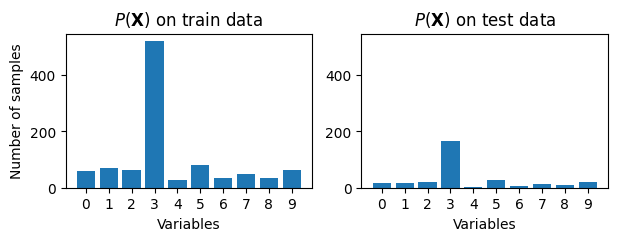

In [6]:
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt


data_p = torch.rand(len(variables))
data_p[3] = 3
data_p = data_p.softmax(dim=-1)
train_P_X = D.OneHotCategorical(probs=data_p).sample(sample_shape=torch.tensor([1000,]))
test_P_X = D.OneHotCategorical(probs=data_p).sample(sample_shape=torch.tensor([300,]))

fig, axs = plt.subplots(1, 2, figsize=(7, 2))

_, train_count = train_P_X.argmax(dim=-1).unique(return_counts=True)
_, test_count = test_P_X.argmax(dim=-1).unique(return_counts=True)

axs[0].bar([str(v) for v in variables], train_count)
axs[0].set_xlabel("Variables")
axs[0].set_ylabel("Number of samples")
axs[0].set_title(r"$P(\mathbf{X})$ on train data")

axs[1].bar([str(v) for v in variables], test_count)
axs[1].set_xlabel("Variables")
axs[1].set_ylim(*axs[0].get_ylim())
axs[1].set_title(r"$P(\mathbf{X})$ on test data")
plt.show()

Let's train the circuit on this dataset.

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

data_train = TensorDataset(train_P_X)
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)

data_test = TensorDataset(test_P_X)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

num_epochs = 50
running_loss = 0
optimizer = optim.Adam(circuit.parameters(), lr=0.9)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss * len(batch)
    print(f"Loss: {running_loss / len(data_train)}")

Loss: 4.154376983642578
Loss: 7.512113094329834
Loss: 11.122591972351074
Loss: 14.499314308166504
Loss: 17.440330505371094
Loss: 20.18540382385254
Loss: 22.83731460571289
Loss: 25.48277473449707
Loss: 28.0847225189209
Loss: 30.676956176757812
Loss: 33.250328063964844
Loss: 35.81651306152344
Loss: 38.38248062133789
Loss: 40.93368911743164
Loss: 43.496028900146484
Loss: 46.03678894042969
Loss: 48.58936309814453
Loss: 51.137699127197266
Loss: 53.68446731567383
Loss: 56.235862731933594
Loss: 58.78200149536133
Loss: 61.322174072265625
Loss: 63.87406921386719
Loss: 66.42188262939453
Loss: 68.96138763427734
Loss: 71.50579833984375
Loss: 74.04815673828125
Loss: 76.59158325195312
Loss: 79.1399917602539
Loss: 81.68509674072266
Loss: 84.23103332519531
Loss: 86.78118133544922
Loss: 89.32804107666016
Loss: 91.87629699707031
Loss: 94.42369842529297
Loss: 96.96971893310547
Loss: 99.52041625976562
Loss: 102.06975555419922
Loss: 104.61616516113281
Loss: 107.1668701171875
Loss: 109.7223129272461
Loss: 1

We can compute the MAP state using brute-force -- i.e. we enumerate all the possible variable assignments and take the one with maximum likelihood.

In [26]:
from itertools import product

assignments = torch.tensor(list(product(*([[0, 1]] * len(variables)))))
assignments_l = circuit(assignments)

# take the assignment with maximum likelihood
map_state = assignments[assignments_l.argmax()]

print("MAP state:", map_state)

MAP state: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


The circuit learned the right distribution: the most probable state is the fourth variable. Unfortunately, we have an exponential number of assignment in the number of variables, hence this approach is not sustainable. 

Since the circuit is smooth, decomposable and deterministic, however, we can perform this operation more efficiently in `cirkit`! Specifically, we can do it in linear time.

In [29]:
from cirkit.backend.torch.queries import MAPQuery

map_query = MAPQuery(circuit)
map_state = map_query()
print("MAP state:", map_state)

MAP state: tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
